In [ ]:
# Takes in the timeseries and apply a custom drift function to the model to predict the x number of observations

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import calendar
from scipy.stats import norm

In [4]:
# GET DATA

def read_excel(file_path=None,sheet_name=0,seriesName="data"):
    if not file_path:
        # GET TIME SERIES
        main_df = pd.read_excel('C:\\Users\\tmpMeesam\\Nutrien\\Ben Bergermann - Canpotex\\Historical Sales Data_Hana Cube.xlsx',sheet_name='MSS Sales')
        main_df['Date'] = main_df.apply(lambda x: datetime(day=calendar.monthrange(x['Accounting Year'],x['Accounting Month'])[1],month=x['Accounting Month'],year=x['Accounting Year']),axis=1)
        total_df = main_df.groupby('Date').sum()

        total_df.drop(['Accounting Month',
         'Accounting Quarter',
         'Accounting Year','Discounts and Rebates (USD)',
         'Gross Sales (USD)'],axis=1,inplace=True)

        total_df['$/MT']=total_df['Netback (USD)']/total_df['Quantity Sold (MT)']

        data = total_df['$/MT']
        return data
        
    else:
        main_df = pd.read_excel(file_path,sheet_name=sheet_name)
        try:
            return main_df[seriesName]
        except:
            return f'ERROR! >> {file_path} | {seriesName}'

In [6]:
def run_monte_carlo_sim(data, forecast:int, sims:int=20000):
    """
    data: series
    forecast: int >> total number of points in the future
    sims: int >> total number of simulations
    Formulas:
        pt = pt-1 * e^r

        r = drift + vol * z

        drift = mean - 0.5*var
        
        st = s0 * daily_return_t

        st+1 = st * daily_return_t

    """
    # Normalize - returns
    log_return = np.log(1+data.pct_change())    
    # Mean
    mean = log_return.mean()
    # Variance
    var = log_return.var()
    # Drift Variable
    drift = mean - 0.5*var
    # Volatility
    vol = log_return.std()
    
    t_intervals = forecast
    iterations = sims
    # Distance From Mean Point
    z = norm.ppf(np.random.rand(t_intervals,iterations))
    # Calculating r >> 
    r = np.exp(drift + vol * z)
    
    # LAST DATAPOINT
    S0 = data[-1]

    price_list = np.zeros_like(z)

    price_list[0] = S0

    for i in range(1,t_intervals):
        price_list[i] = price_list[i-1] * r[i]
        
    return price_list

In [12]:
price_list = run_monte_carlo_sim(read_excel(),3,500)

In [13]:
f"Next Month: ${int(min(price_list[1]))} | ${round(price_list[0][0],2)} | ${int(max(price_list[1]))}"

'Next Month: $499 | $712.29 | $1025'

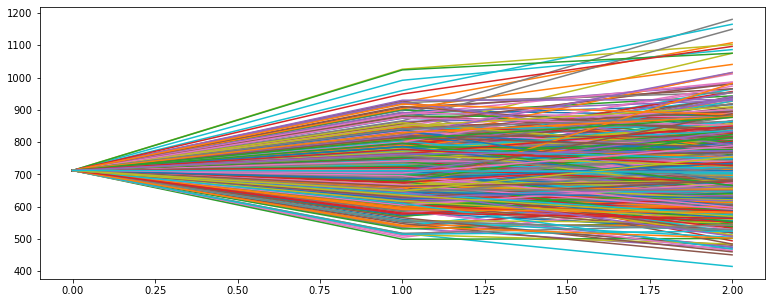

In [14]:
plt.figure(figsize=(13,5))
plt.plot(price_list);

In [ ]:
# Expected Value > phi * outcome